# Repurchase model

Repurchase models explains the likelihood that a customer will make a repeat purchase or buy a product or service again. It is a key metric used to assess the probability of customer retention or loyalty. 

The script is similar to the one for churn prediction except for the target variable which in this case is the binary **oneshooter** which takes the value 1 if the customer has made only one purchase in the reference period, 0 otherwise.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import shap
import warnings
warnings.filterwarnings("ignore")

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import the dataset and drop customer ID column:

In [ ]:
df = pd.read_csv('repurchase.csv')
df = df.drop('customer_id', axis=1)
df

,Recency,Monetary,oneshooter,yes_review,age,days_from_activation,yes_refund,gender_male,region_abruzzo,region_basilicata,...,region_sicilia,region_toscana,region_trentino alto adige,region_umbria,region_valle d'aosta,region_veneto,loyalty_type_business premium,loyalty_type_business standard,loyalty_type_premium,loyalty_type_standard
0,69,483.51,0,1,44,234,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,281,10179.56,0,0,44,323,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,28,58.85,0,1,34,46,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1053.62,0,0,68,265,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,70,28.75,0,1,43,158,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102364,0,39.10,1,1,43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
102365,0,33.60,1,1,43,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
102366,0,21.98,1,1,59,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
102367,0,1.90,1,1,43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


We normalise the numerical variables to a range of 0-1 and divide the data into training (80%) and test set (20%):

In [ ]:
x = df.drop('oneshooter', axis=1)
y = df['oneshooter']

columns_to_normalize = ['age', 'days_from_activation', 'Recency', 'Monetary']
x[columns_to_normalize] = MinMaxScaler().fit_transform(x[columns_to_normalize])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Looking at the distribution of one-shooters in the training set, we see that the problem of unbalanced classes is not so pronounced (32% one-shooters)

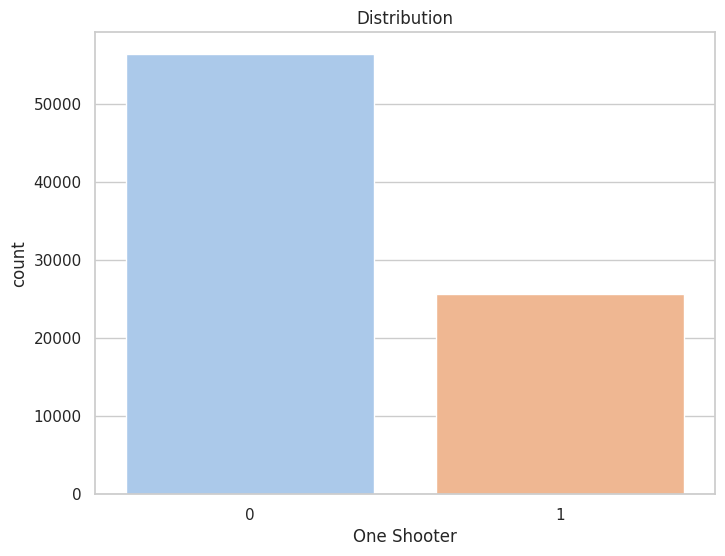

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.countplot(x=y_train, palette='pastel')

plt.xlabel('One Shooter')
plt.title('Distribution')

plt.show()

In [ ]:
y_train.value_counts() # 68-32

0    56309
1    25586
Name: oneshooter, dtype: int64

Let's now define the classification models.

## Logistic model

In [ ]:
logistic_model = LogisticRegression(random_state=42)

In [ ]:
logistic_model.fit(x_train, y_train)
y_pred_log = logistic_model.predict(x_test)

See the performance of logistic model on the test set:

In [ ]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83     14115
           1       0.63      0.50      0.56      6359

    accuracy                           0.75     20474
   macro avg       0.71      0.69      0.70     20474
weighted avg       0.74      0.75      0.75     20474



In [ ]:
accuracy_log = accuracy_score(y_test, y_pred_log)
precision_log = precision_score(y_test, y_pred_log)
recall_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)
auc_log = roc_auc_score(y_test, logistic_model.predict_proba(x_test)[:, 1])

print('Logistic Accuracy:', accuracy_log)
print('Logistic Precision:', precision_log)
print('Logistic Recall:', recall_log)
print('Logistic F1-score:', f1_log)
print('Logistic AUC:', auc_log)

Logistic Accuracy: 0.7549575070821529
Logistic Precision: 0.6330821102737009
Logistic Recall: 0.5019657178801699
Logistic F1-score: 0.5599508815016226
Logistic AUC: 0.8037312403110233


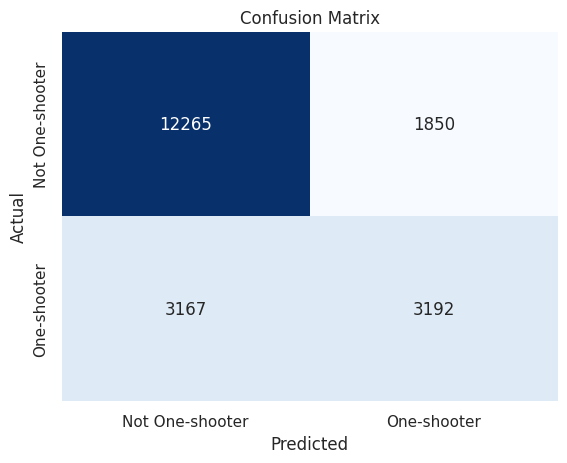

In [ ]:
cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not One-shooter', 'One-shooter'], yticklabels=['Not One-shooter', 'One-shooter'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)

In [ ]:
dt_model.fit(x_train, y_train)
y_pred_dt = dt_model.predict(x_test)

See the performance of decision tree model on the test set:

In [ ]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     14115
           1       0.66      0.66      0.66      6359

    accuracy                           0.79     20474
   macro avg       0.75      0.75      0.75     20474
weighted avg       0.79      0.79      0.79     20474



In [ ]:
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, dt_model.predict_proba(x_test)[:, 1])

print('Decision Tree Accuracy:', accuracy_dt)
print('Decision Tree Precision:', precision_dt)
print('Decision Tree Recall:', recall_dt)
print('Decision Tree F1-score:', f1_dt)
print('Decision Tree AUC:', auc_dt)

Decision Tree Accuracy: 0.7883657321480902
Decision Tree Precision: 0.659176618478944
Decision Tree Recall: 0.6596949205849977
Decision Tree F1-score: 0.6594356676884384
Decision Tree AUC: 0.7530143040757081


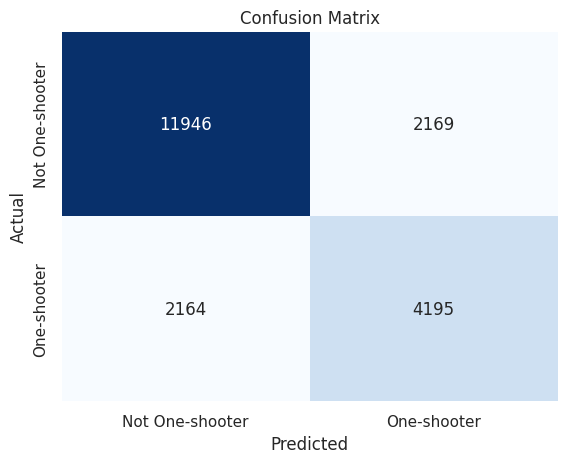

In [ ]:
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not One-shooter', 'One-shooter'], yticklabels=['Not One-shooter', 'One-shooter'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

In [ ]:
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

See the performance of random forest model on the test set:

In [ ]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89     14115
           1       0.77      0.68      0.72      6359

    accuracy                           0.84     20474
   macro avg       0.82      0.80      0.80     20474
weighted avg       0.84      0.84      0.84     20474



In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, rf_model.predict_proba(x_test)[:, 1])

print('Random Forest Accuracy:', accuracy_rf)
print('Random Forest Precision:', precision_rf)
print('Random Forest Recall:', recall_rf)
print('Random Forest F1-score:', f1_rf)
print('Random Forest AUC:', auc_rf)

Random Forest Accuracy: 0.8383803848783823
Random Forest Precision: 0.770198440822112
Random Forest Recall: 0.6835980500078629
Random Forest F1-score: 0.7243189202699325
Random Forest AUC: 0.9025885308362436


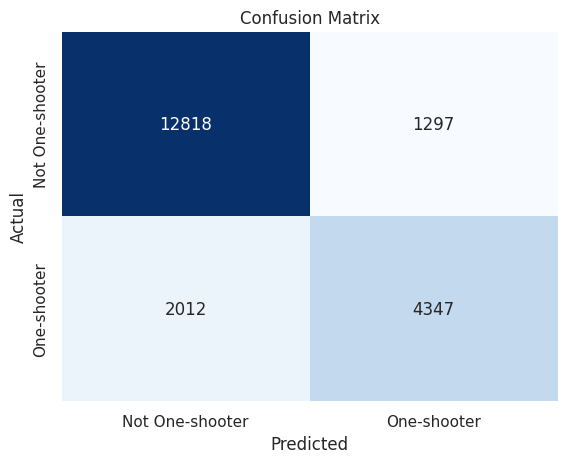

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not One-shooter', 'One-shooter'], yticklabels=['Not One-shooter', 'One-shooter'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42)

In [ ]:
xgb_model.fit(x_train, y_train)
y_pred_xgb = xgb_model.predict(x_test)

See the performance of XGBoost model on the test set:

In [ ]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     14115
           1       0.79      0.72      0.75      6359

    accuracy                           0.85     20474
   macro avg       0.83      0.81      0.82     20474
weighted avg       0.85      0.85      0.85     20474



In [ ]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(x_test)[:, 1])

print('XGBoost Accuracy:', accuracy_xgb)
print('XGBoost Precision:', precision_xgb)
print('XGBoost Recall:', recall_xgb)
print('XGBoost F1-score:', f1_xgb)
print('XGBoost AUC:', auc_xgb)

XGBoost Accuracy: 0.8514701572726384
XGBoost Precision: 0.7871235721703012
XGBoost Recall: 0.7152067935209939
XGBoost F1-score: 0.7494438493861745
XGBoost AUC: 0.9153437071988085


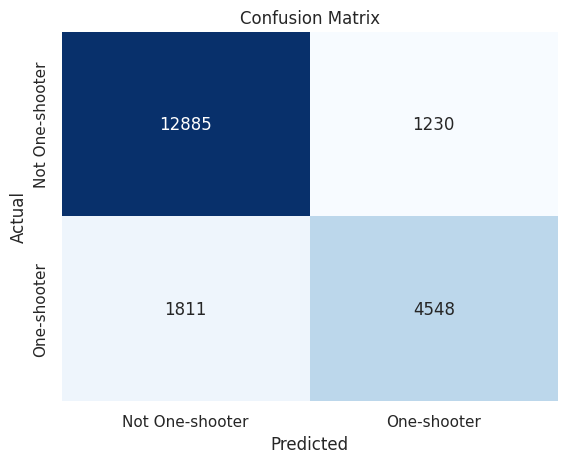

In [ ]:
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not One-shooter', 'One-shooter'], yticklabels=['Not One-shooter', 'One-shooter'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Multilayer Perceptron

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes=(5,), random_state=42) # 5 hidden layer

In [ ]:
mlp_model.fit(x_train, y_train)
y_pred_mlp = mlp_model.predict(x_test)

See the performance of Multilayer Perceptron model on the test set:

In [ ]:
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86     14115
           1       0.73      0.51      0.60      6359

    accuracy                           0.79     20474
   macro avg       0.77      0.71      0.73     20474
weighted avg       0.78      0.79      0.78     20474



In [ ]:
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)
auc_mlp = roc_auc_score(y_test, mlp_model.predict_proba(x_test)[:, 1])

print('Multilayer Perceptron Accuracy:', accuracy_mlp)
print('Multilayer Perceptron Precision:', precision_mlp)
print('Multilayer Perceptron Recall:', recall_mlp)
print('Multilayer Perceptron F1-score:', f1_mlp)
print('Multilayer Perceptron AUC:', auc_mlp)

Multilayer Perceptron Accuracy: 0.7902705870860603
Multilayer Perceptron Precision: 0.7332279195843686
Multilayer Perceptron Recall: 0.5104576191225035
Multilayer Perceptron F1-score: 0.6018913406267383
Multilayer Perceptron AUC: 0.8367141452640864


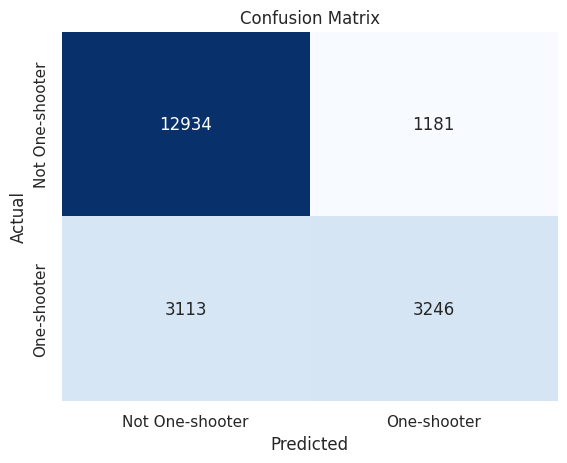

In [ ]:
cm = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not One-shooter', 'One-shooter'], yticklabels=['Not One-shooter', 'One-shooter'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## ROC curves

In [ ]:
y_prob_log = LogisticRegression(random_state=42).fit(x_train, y_train).predict_proba(x_test)[:,1]
y_prob_dt = DecisionTreeClassifier(random_state=42).fit(x_train, y_train).predict_proba(x_test)[:,1]
y_prob_rf = RandomForestClassifier(random_state=42).fit(x_train, y_train).predict_proba(x_test)[:,1]
y_prob_xgb = xgb.XGBClassifier(random_state=42).fit(x_train, y_train).predict_proba(x_test)[:,1]
y_prob_mlp = MLPClassifier(hidden_layer_sizes=(5,), random_state=42).fit(x_train, y_train).predict_proba(x_test)[:,1]

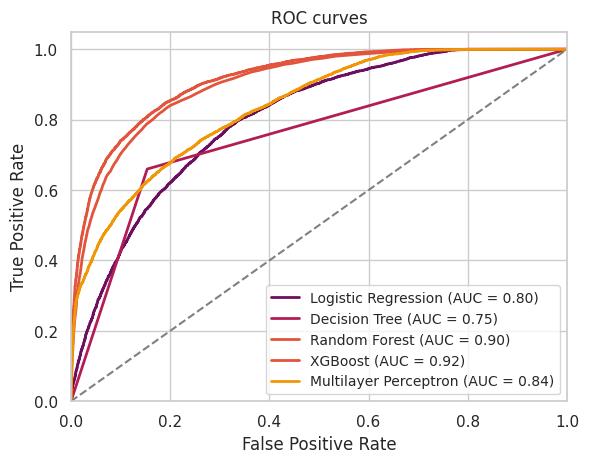

In [ ]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)

plt.plot(fpr_log, tpr_log, color='#6c0f5e', lw=2, label='Logistic Regression (AUC = {:.2f})'.format(auc_log))
plt.plot(fpr_dt, tpr_dt, color='#b31d56', lw=2, label='Decision Tree (AUC = {:.2f})'.format(auc_dt))
plt.plot(fpr_rf, tpr_rf, color='#e2543b', lw=2, label='Random Forest (AUC = {:.2f})'.format(auc_rf))
plt.plot(fpr_xgb, tpr_xgb, color='#e2543b', lw=2, label='XGBoost (AUC = {:.2f})'.format(auc_xgb))
plt.plot(fpr_mlp, tpr_mlp, color='#f09708', lw=2, label='Multilayer Perceptron (AUC = {:.2f})'.format(auc_mlp))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc='lower right', fontsize='small')
plt.show()

The best performing model is the XGBoost.
Let us therefore see which variables are the most decisive in classifying the observations:

In [ ]:
feature_importance = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance:")
feature_importance_df.head()

Feature Importance:


,Feature,Importance
5,yes_refund,0.572677
1,Monetary,0.121180
0,Recency,0.042786
4,days_from_activation,0.041835
3,age,0.024653


The most decisive variable is 'yes_refund', which indicates whether a review has been made or not. This is followed by Monetary, Recency and so on.

Now we use SHapley Additive exPlanations (SHAP) to explain the overall behavior of the model across all predictions (global explanation).
Moreover SHAP values provide a clear and intuitive interpretation of how each feature influences the model's output. This is crucial for understanding the factors driving a particular prediction, making machine learning models more transparent and interpretable.

In [ ]:
# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x_test)

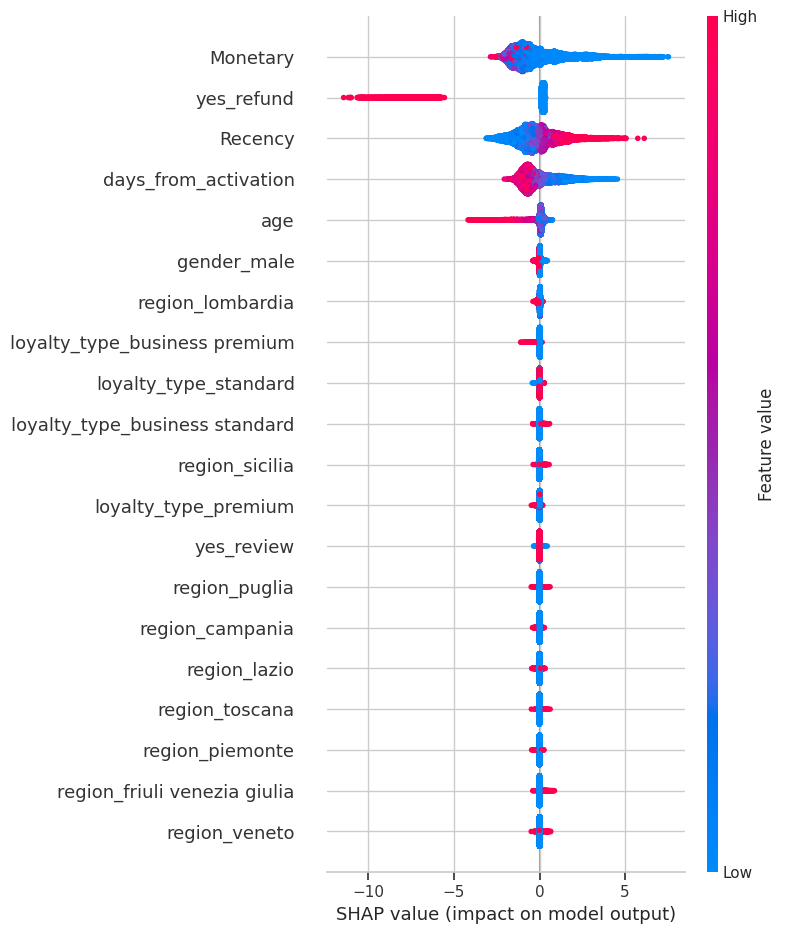

In [ ]:
# Plot summary plot using SHAP values for all predictions
shap.summary_plot(shap_values, x_test)

Each point on the plot represents a Shapley value for a feature and an instance. The position on the x-axis indicates the SHAP value, which shows the impact on the model output. A point's color represents the feature value (high or low).

As shown in the figure **Monetary** and **yes_refund** features have a high positive impact on the model's prediction; lower values of Monetary increase the prediction while the fact of having written a review negatively affects being classified as a one-shooter.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fad4abbb-8bc7-4ee9-9f5c-63fc95d85e92' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>